In [1]:
import sys
sys.path.append('../src/')

from almaDatabaseQuery import *

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### ALL 

In [2]:
q = databaseQuery()
report, resume = q.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db", \
                                    maxFreqRes=999999999, array='12m', \
                                    excludeCycle0=True, \
                                    selectPol=False, \
                                    minTimeBand={3:60., 6:60., 7:60.}, \
                                    silent=True)

Number of accepted source:  186


In [3]:
q.write_report(report, "report_8.txt", silent=True)

#################################
### Total Number of Sources : 186 



In [4]:
print "Number of object = ", len(resume)

Number of object =  186


In [5]:
# remove None from list of redshift
z = [] 
for idata in resume:
    if idata[6] is not None:
        z.append(idata[6])

In [6]:
print "Known redshift (from NED) = ", len(z)

Known redshift (from NED) =  146


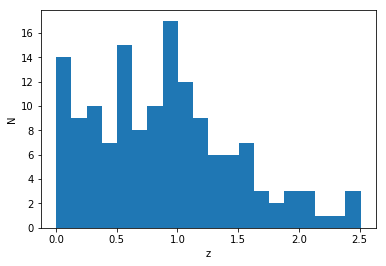

In [7]:
plt.hist(z, bins=20)
plt.xlabel("z")
plt.ylabel("N")

### NON ALMACAL

In [8]:
q2 = databaseQuery()
report2, resume2 = q2.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db", \
                                    maxFreqRes=999999999, array='12m', \
                                    excludeCycle0=True, \
                                    selectPol=False, \
                                    minTimeBand={3:60., 6:60., 7:60.}, \
                                    nonALMACAL=True, \
                                    silent=True)

Number of accepted source:  134


In [9]:
q2.write_report(report2, "report_8_nonAlmacal.txt", silent=True)

#################################
### Total Number of Sources : 134 



In [10]:
z2 = []
for idata in resume2:
    if idata[6] is not None:
        z2.append(idata[6])

In [11]:
print "Known redshift (from NED) = ", len(z2)

Known redshift (from NED) =  99


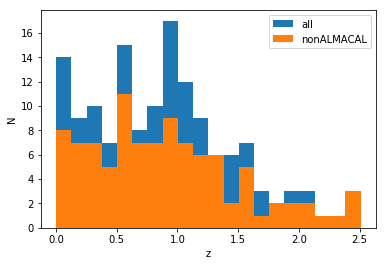

In [12]:
plt.hist(z, bins=20, label="all")
plt.hist(z2, bins=20, label="nonALMACAL")
plt.legend()
plt.xlabel("z")
plt.ylabel("N")
plt.show()

### POLAMI

In [13]:
q3 = databaseQuery()
report3,resume3 = q3.select_object_from_sqldb("calibrators_brighterthan_0.1Jy_20180419.db",\
                                               maxFreqRes=999999999, array='12m', \
                                               excludeCycle0=True, \
                                               selectPol=True, \
                                               minTimeBand={3:0., 6:0., 7:0.}, 
                                               verbose=True, silent=True)

Number of accepted source:  86


In [14]:
q3.write_report(report3, "report_8_pol.txt", silent=True)

#################################
### Total Number of Sources : 86 



In [15]:
# remove None from list of redshift
z3 = [] 
for idata in resume3:
    if idata[6] is not None:
        z3.append(idata[6])

In [16]:
print "Known redshift (from NED) = ", len(z3)

Known redshift (from NED) =  55


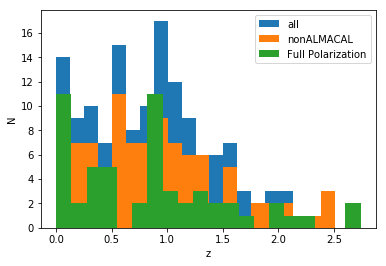

In [17]:
plt.hist(z, bins=20, label="all")
plt.hist(z2, bins=20, label="nonALMACAL")
plt.hist(z3, bins=20, label="Full Polarization")
plt.legend()
plt.xlabel("z")
plt.ylabel("N")
plt.show()